In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input/solar-power-generation-data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../input/solar-power-generation-data/Plant_2_Generation_Data.csv
../input/solar-power-generation-data/Plant_2_Weather_Sensor_Data.csv
../input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv
../input/solar-power-generation-data/Plant_1_Generation_Data.csv


# Import libraries und data files

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_decomposition import PLSRegression
import warnings
warnings.filterwarnings("ignore")

In [3]:
generation_data = pd.read_csv('../input/solar-power-generation-data/Plant_1_Generation_Data.csv')
weather_data = pd.read_csv('../input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv')

# Get overview of data

In [4]:
generation_data.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [5]:
weather_data.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


In [6]:
print(generation_data['SOURCE_KEY'].unique().size)
print(weather_data['SOURCE_KEY'].unique().size)

print(generation_data['PLANT_ID'].unique().size)
print(weather_data['PLANT_ID'].unique().size)

22
1
1
1


In [7]:
generation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB


In [8]:
generation_data.describe()

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,68778.0,68778.000000,68778.000000,68778.000000,6.877800e+04
mean,4135001.0,3147.426211,307.802752,3295.968737,6.978712e+06
std,0.0,4036.457169,394.396439,3145.178309,4.162720e+05
min,4135001.0,0.000000,0.000000,0.000000,6.183645e+06
25%,4135001.0,0.000000,0.000000,0.000000,6.512003e+06
50%,4135001.0,429.000000,41.493750,2658.714286,7.146685e+06
75%,4135001.0,6366.964286,623.618750,6274.000000,7.268706e+06
max,4135001.0,14471.125000,1410.950000,9163.000000,7.846821e+06


# Format datetime columns and merge Data Frames

In [9]:
generation_data['DATE_TIME'] = pd.to_datetime(generation_data["DATE_TIME"])
weather_data['DATE_TIME'] = pd.to_datetime(weather_data["DATE_TIME"])

In [10]:
df = pd.merge(generation_data.drop(columns=['PLANT_ID']), weather_data.drop(columns=['PLANT_ID', 'SOURCE_KEY']), on='DATE_TIME')

In [11]:
df.head()

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,25.184316,22.857507,0.0
1,2020-05-15,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,25.184316,22.857507,0.0
2,2020-05-15,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,25.184316,22.857507,0.0
3,2020-05-15,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,25.184316,22.857507,0.0
4,2020-05-15,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,25.184316,22.857507,0.0


# Looking for null and missing values

In [12]:
df.isnull().sum()

DATE_TIME              0
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64

In [13]:
df.describe()

,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,68774,68774.000000,68774.000000,68774.000000,6.877400e+04,68774.000000,68774.000000,68774.000000
mean,2020-06-01 08:02:38.161514240,3147.177450,307.778375,3295.834644,6.978728e+06,25.558521,31.244997,0.232305
min,2020-05-15 00:00:00,0.000000,0.000000,0.000000,6.183645e+06,20.398505,18.140415,0.000000
25%,2020-05-24 00:33:45,0.000000,0.000000,0.000000,6.512007e+06,22.724491,21.123944,0.000000
50%,2020-06-01 14:15:00,428.571429,41.450000,2658.473214,7.146685e+06,24.670178,24.818984,0.031620
75%,2020-06-09 20:00:00,6365.468750,623.561161,6274.000000,7.268751e+06,27.960429,41.693659,0.454880
max,2020-06-17 23:45:00,14471.125000,1410.950000,9163.000000,7.846821e+06,35.252486,65.545714,1.221652
std,NaN,4036.441826,394.394865,3145.220597,4.162707e+05,3.361300,12.308283,0.301948


In [14]:
df.count()

DATE_TIME              68774
SOURCE_KEY             68774
DC_POWER               68774
AC_POWER               68774
DAILY_YIELD            68774
TOTAL_YIELD            68774
AMBIENT_TEMPERATURE    68774
MODULE_TEMPERATURE     68774
IRRADIATION            68774
dtype: int64

# Check for correlation of input fields

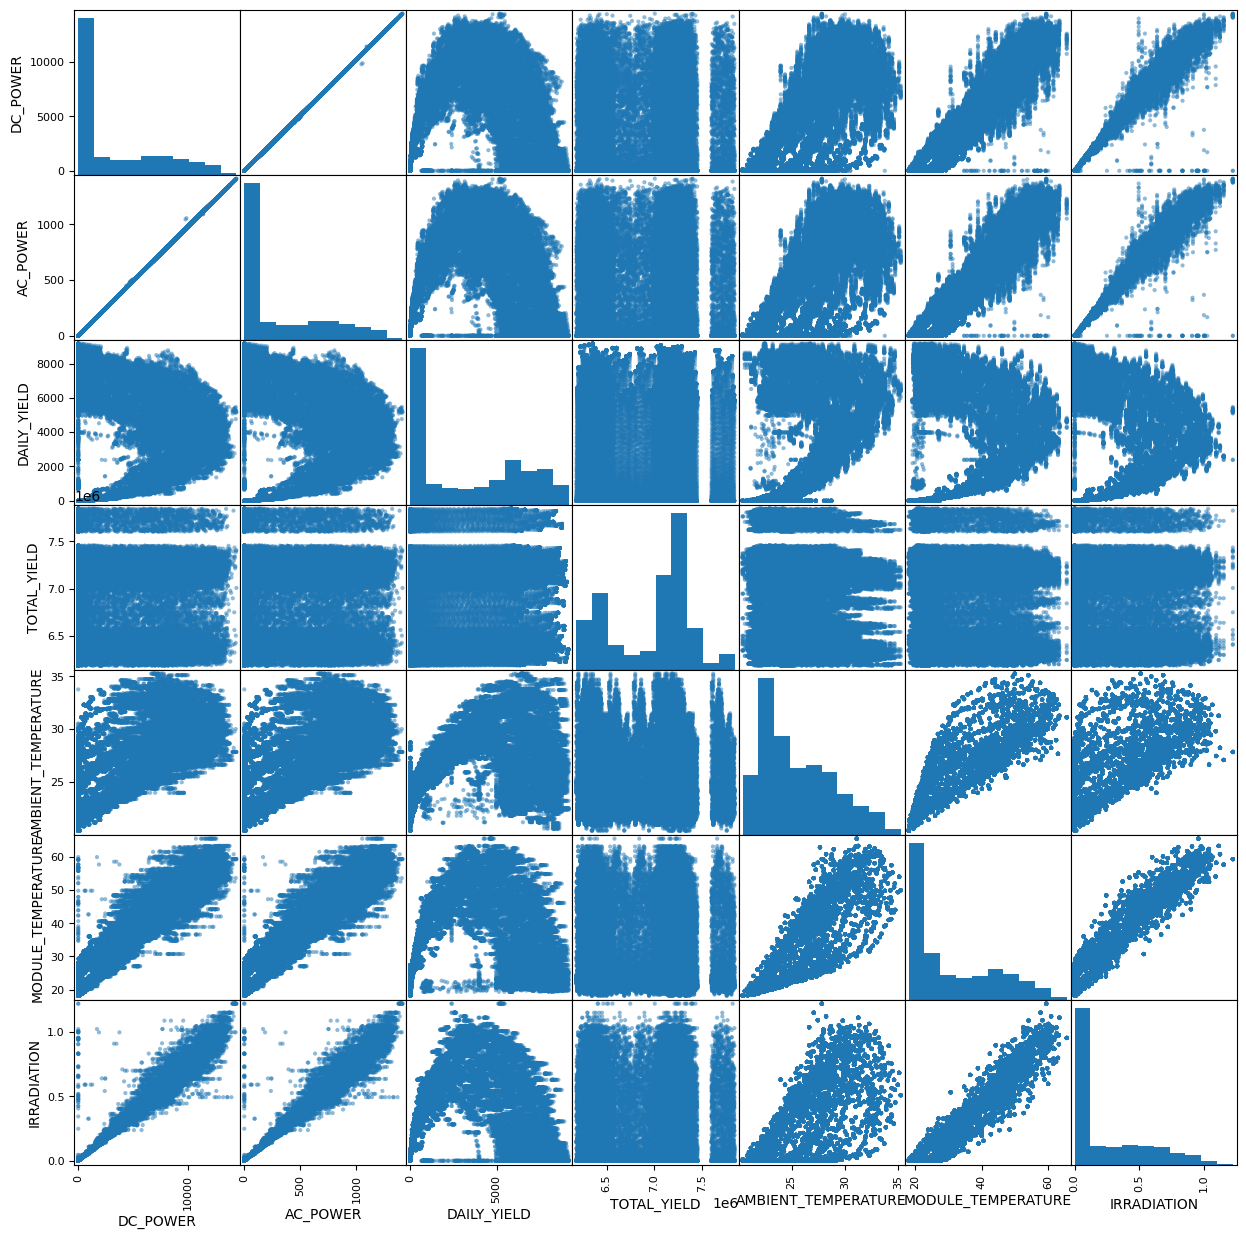

In [15]:
pd.plotting.scatter_matrix(df, figsize=(15,15))

plt.show()

In [16]:
corr = df.select_dtypes(include=[np.number]).corr()
corr.style.background_gradient(cmap='coolwarm')

,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DC_POWER,1.000000,0.999996,0.082243,0.003851,0.724668,0.954811,0.989391
AC_POWER,0.999996,1.000000,0.082193,0.003840,0.724903,0.954924,0.989340
DAILY_YIELD,0.082243,0.082193,1.000000,0.009896,0.478496,0.198308,0.078317
TOTAL_YIELD,0.003851,0.003840,0.009896,1.000000,-0.036150,-0.015596,-0.005490
AMBIENT_TEMPERATURE,0.724668,0.724903,0.478496,-0.036150,1.000000,0.855420,0.725278
MODULE_TEMPERATURE,0.954811,0.954924,0.198308,-0.015596,0.855420,1.000000,0.961511
IRRADIATION,0.989391,0.989340,0.078317,-0.005490,0.725278,0.961511,1.000000


# Convert 'SOURCE_KEY' to numerical type

In [17]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df['SOURCE_KEY_NUMBER'] = encoder.fit_transform(df['SOURCE_KEY'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68774 entries, 0 to 68773
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            68774 non-null  datetime64[ns]
 1   SOURCE_KEY           68774 non-null  object        
 2   DC_POWER             68774 non-null  float64       
 3   AC_POWER             68774 non-null  float64       
 4   DAILY_YIELD          68774 non-null  float64       
 5   TOTAL_YIELD          68774 non-null  float64       
 6   AMBIENT_TEMPERATURE  68774 non-null  float64       
 7   MODULE_TEMPERATURE   68774 non-null  float64       
 8   IRRADIATION          68774 non-null  float64       
 9   SOURCE_KEY_NUMBER    68774 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 5.2+ MB


# Solar Power Prediction

### Preparation

In [18]:
df_ml = df.copy()
X = df[['DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE','MODULE_TEMPERATURE', 'IRRADIATION']]
y = df['AC_POWER']

In [19]:
print(X)
print(y)

       DAILY_YIELD  TOTAL_YIELD  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  \
0            0.000    6259559.0            25.184316           22.857507   
1            0.000    6183645.0            25.184316           22.857507   
2            0.000    6987759.0            25.184316           22.857507   
3            0.000    7602960.0            25.184316           22.857507   
4            0.000    7158964.0            25.184316           22.857507   
...            ...          ...                  ...                 ...   
68769     5967.000    7287002.0            21.909288           20.427972   
68770     5147.625    7028601.0            21.909288           20.427972   
68771     5819.000    7251204.0            21.909288           20.427972   
68772     5817.000    6583369.0            21.909288           20.427972   
68773     5910.000    7363272.0            21.909288           20.427972   

       IRRADIATION  
0              0.0  
1              0.0  
2              0.0  
3  

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### Partial least squares (PLS)

In [21]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
# Train PLS Regression Model
pls = PLSRegression(n_components=3)
pls.fit(X_train, y_train)

# Predict and evaluate on the test set
y_pred = pls.predict(X_test)
y_pred2 = pls.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"R²: {r2}")


RMSE: 59.56158980729744
R²: 0.9770091947659579


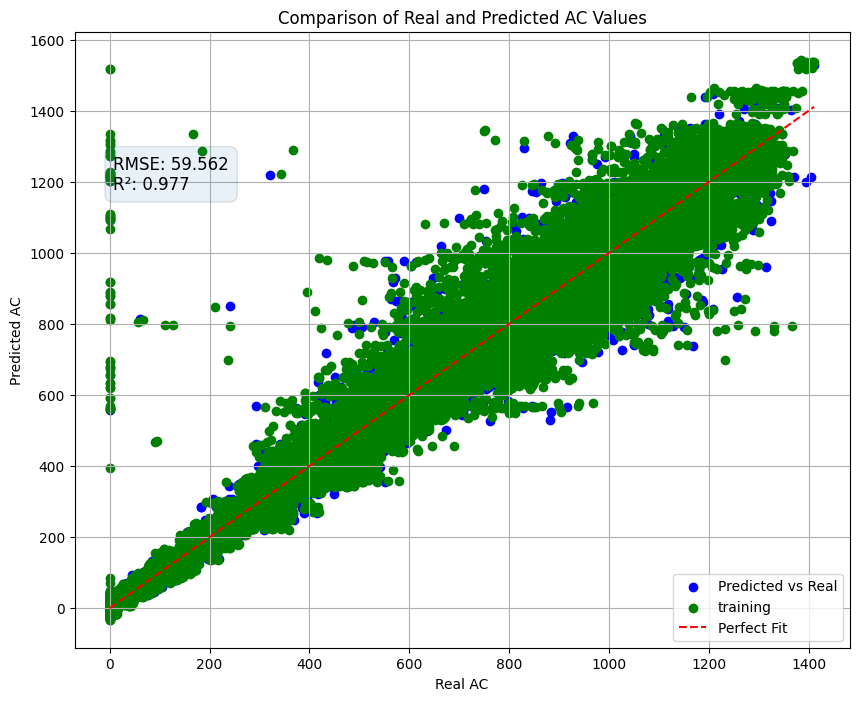

In [22]:
# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Real')  
plt.scatter(y_train, y_pred2, color='green', label='training')  
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label='Perfect Fit')
plt.text(x=0.05, y=0.8, s=f'RMSE: {rmse:.3f}\nR²: {r2:.3f}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', alpha=0.1))

plt.xlabel('Real AC')
plt.ylabel('Predicted AC')
plt.title('Comparison of Real and Predicted AC Values')
plt.legend()
plt.grid(True)
plt.show()

### Linear Regression

In [23]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_score = lr_model.score(X_test, y_test)
print(f"Score is {lr_score*100:.4f} %")

Score is 98.0130 %


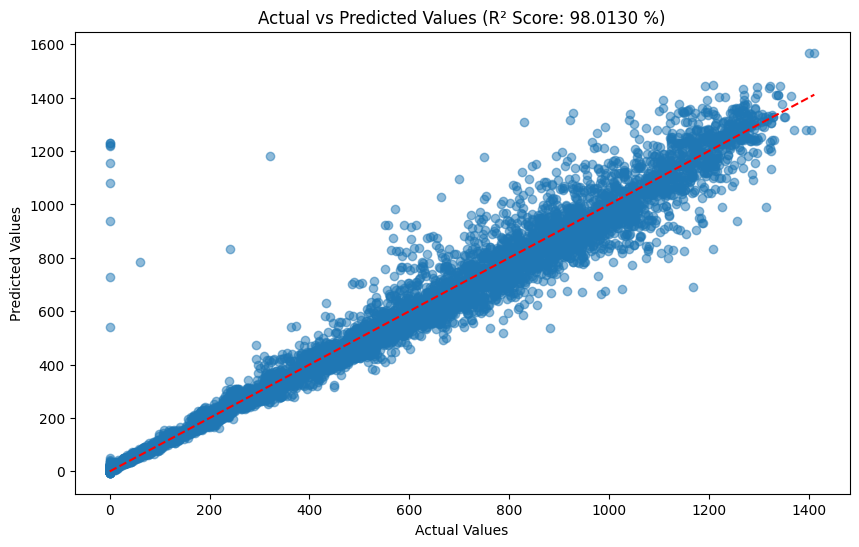

In [24]:
import matplotlib.pyplot as plt

# Assuming you have already trained your Linear Regression model and have your predictions
y_pred = lr_model.predict(X_test)

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Line of perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted Values (R² Score: {lr_score*100:.4f} %)')
plt.show()


### kNN

In [25]:
from sklearn import neighbors

score_list = []
n_neighbors_list = []

# for loop to find best fitting n_neighbor value
for i in range(1, 21):
    knn = neighbors.KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train, y_train)

    knn_score = knn.score(X_test, y_test)

    score_list.append(knn_score)
    n_neighbors_list.append(i)

best_n_neighbor = n_neighbors_list[score_list.index(max(score_list))]
print(f"Best n_neighbor at {best_n_neighbor} with {max(score_list)*100:.4f} %")


Best n_neighbor at 3 with 86.9849 %


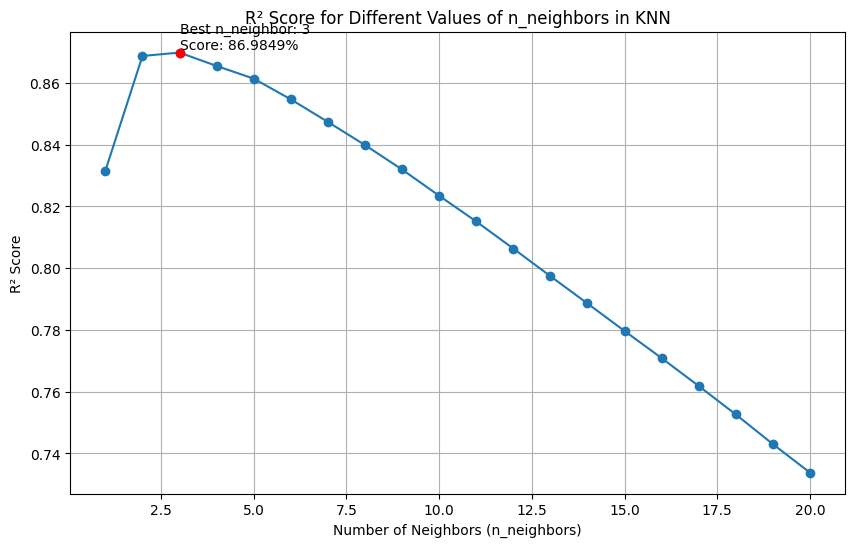

Best n_neighbor at 3 with 86.9849 %


In [26]:
import matplotlib.pyplot as plt

# Assuming you have run the loop and have your score_list and n_neighbors_list
# Plot the scores against the number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(n_neighbors_list, score_list, marker='o')
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('R² Score')
plt.title('R² Score for Different Values of n_neighbors in KNN')
plt.grid(True)

# Highlight the best n_neighbors
best_n_neighbor = n_neighbors_list[score_list.index(max(score_list))]
best_score = max(score_list)
plt.scatter([best_n_neighbor], [best_score], color='red', zorder=5)
plt.text(best_n_neighbor, best_score, f'Best n_neighbor: {best_n_neighbor}\nScore: {best_score*100:.4f}%', 
         horizontalalignment='left', verticalalignment='bottom')

plt.show()

print(f"Best n_neighbor at {best_n_neighbor} with {best_score*100:.4f} %")


### Decision Tree

In [27]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
dtr.fit(X_train,y_train)

dtr_score = dtr.score(X_test, y_test)
print(f"Score is {dtr_score*100:.4f} %")

Score is 98.4982 %


### Random Forest

In [28]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)

rfr_score = rfr.score(X_test, y_test)
print(f"Score is {rfr_score*100:.4f} %")

Score is 99.0929 %


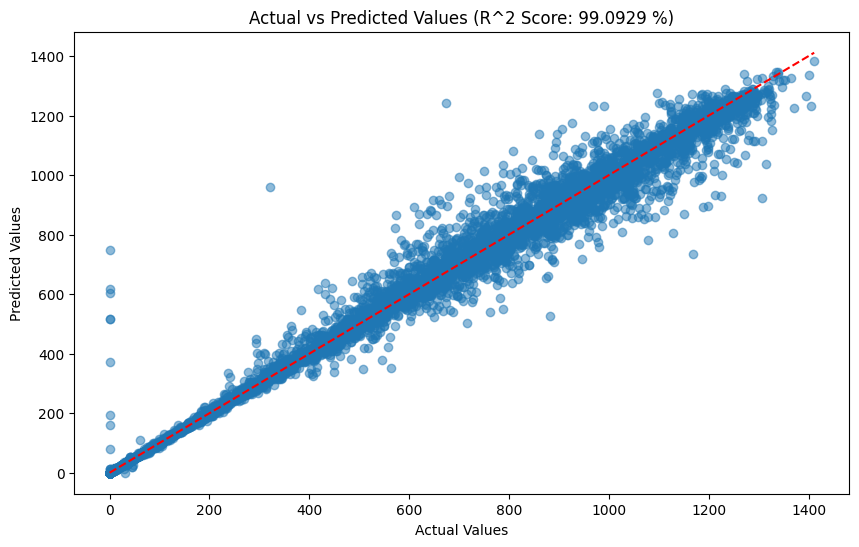

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already trained your RandomForestRegressor and have your predictions
y_pred = rfr.predict(X_test)

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Line of best fit
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted Values (R^2 Score: {rfr_score*100:.4f} %)')
plt.show()
